<a href="https://colab.research.google.com/github/youkjang/Machine-Learning-Deep-Learning-Practice/blob/main/storm_prediction_ROC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification Problems: Receiver Operating Characteristic (ROC) curve

## Compare ML Algorithms for Storm Prediction
1. Preprocessing: select inputs, split the datasets, and normalization
2. Build models: Logistic Regression, Random Forest, Naive Bayes, KNN, SVM, XGBoost, and Gradient Boosting
3. Computing AUROC and ROC

## Input variables
- REFL_COM_mean (composite reflectivity)

- U10_mean, U10_max (10 m west-east wind component in m/s)

- V10_mean, V10_max (10 m south-north wind component in m/s)

- T2_mean, T2_max (2 m temperature in Kelvin)

## Output variables
- Based on Vorticity, strong rotation as 1 and weak or no rotation as 0

## data
https://github.com/djgagne/ams-ml-python-course/blob/master/download_data.py
## Reference
- https://github.com/dataprofessor/code/blob/master/python/ROC_curve.ipynb
- https://github.com/djgagne/ams-ml-python-course/blob/master/module_3/ML_Short_Course_Module_3_Deep_Learning.ipynb

 



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob

## Load CSV file

In [2]:
csv_files = sorted(glob.glob("*.csv"))
csv_data_list = []
for csv_file in csv_files:
    csv_data_list.append(pd.read_csv(csv_file))
csv_data = pd.concat(csv_data_list, ignore_index=True)
del csv_data_list

## Pre-Processing for Deep Learning
### Select Variables
- Input & output variables

In [3]:
input_columns = ["REFL_COM_mean", "U10_mean", "V10_mean", "T2_mean",
                 "U10_max", "V10_max", "T2_max"]
output_column = "RVORT1_MAX-future_max"

## Split dataset into trainning and test data

In [4]:
train_test_date = pd.Timestamp("2015-01-01")
valid_dates = pd.DatetimeIndex(csv_data["Valid_Date"])

- Vorticity threshold in $s^{-1}$

In [5]:
out_threshold = 0.005

- Input training data : 2010-10-24 ~ 2014-11-24
- Output (Label) : RVORT1_MAX-future_max, strong rotation as 1 and weak or no rotation as 0

In [6]:
train_data = csv_data.loc[valid_dates < train_test_date, input_columns]

train_out = np.where(csv_data.loc[valid_dates < train_test_date, output_column] > out_threshold, 1, 0)

- Input test data: 2015-3-31 ~ 2017-3-30
- Output test: strong rotation as 1 and weak or no rotation as 0

In [7]:
test_data = csv_data.loc[valid_dates >= train_test_date, input_columns]

test_out = np.where(csv_data.loc[valid_dates >= train_test_date, output_column] > out_threshold, 1, 0)

## Normalize Input for classification models

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_norm = scaler.fit_transform(train_data)
test_norm = scaler.transform(test_data)
for i, input_col in enumerate(input_columns):
    print(f"{input_columns[i]:13s} Mean: {scaler.mean_[i]:0.3f} SD: {scaler.scale_[i]:0.3f}")

REFL_COM_mean Mean: 46.847 SD: 3.984
U10_mean      Mean: 0.450 SD: 4.348
V10_mean      Mean: 0.543 SD: 4.462
T2_mean       Mean: 289.409 SD: 6.932
U10_max       Mean: 3.764 SD: 5.261
V10_max       Mean: 3.898 SD: 5.066
T2_max        Mean: 290.693 SD: 7.124


## Build classification model
### Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegression
lreg = LogisticRegression()
lreg.fit(train_norm,train_out)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_features=5, n_estimators=100)
rf.fit(train_norm,train_out)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

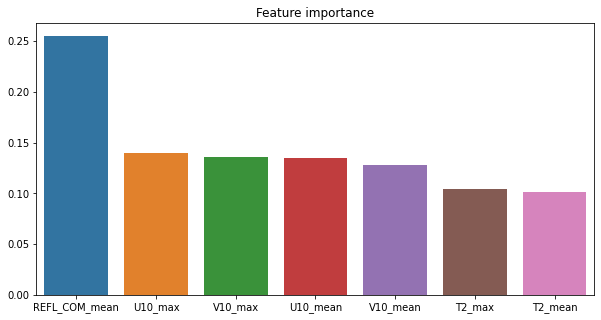

In [11]:
imp = pd.Series(data=rf.feature_importances_, index=train_data.columns).sort_values(ascending=False)
plt.figure(figsize=(10,5))
plt.title("Feature importance")
ax = sns.barplot(x=imp.index, y=imp.values)

###Naive Bayes

In [12]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(train_norm, train_out)

GaussianNB(priors=None, var_smoothing=1e-09)

### K-NN, K-nearest neighbors vote 

In [13]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 6,metric ='minkowski', p = 2)
knn.fit(train_norm, train_out)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                     weights='uniform')

### Support Vector Machine Classifier

In [14]:
from sklearn.svm import SVC
svc = SVC(kernel = 'rbf', probability=True)
svc.fit(train_norm, train_out)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

###XGBoost Classifier

In [15]:
import xgboost 
xgb = xgboost.XGBClassifier()
xgb.fit(train_norm,train_out)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

###Gradient Boosting Classifier

In [16]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(train_norm,train_out)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

## Prediction probabilities
* r_probs: Random prediction
* lreg_probs: Logistic Regression
* rf_probs: Random Forest
* nb_probs: Naive Bayes
* knn_probs: K-nearest neighbors
* svc_probs: Support Vector Machine Classifier
* xgb_probs: XGBoost Classifier
* gbc_probs: Gradient Boosting Classifier

In [17]:
r_probs = [0 for _ in range(len(test_norm))]
lreg_probs = lreg.predict_proba(test_norm)
rf_probs = rf.predict_proba(test_norm)
nb_probs = nb.predict_proba(test_norm)
knn_probs = knn.predict_proba(test_norm)
svc_probs = svc.predict_proba(test_norm)
xgb_probs = xgb.predict_proba(test_norm)
gbc_probs = gbc.predict_proba(test_norm)

### Probabilities for the positive outcome

In [18]:
lreg_probs = lreg_probs[:,1]
rf_probs = rf_probs[:,1]
nb_probs = nb_probs[:,1]
knn_probs = knn_probs[:,1]
svc_probs = svc_probs[:,1]
xgb_probs = xgb_probs[:,1]
gbc_probs = gbc_probs[:,1]

## Computing AUROC and ROC curve values

In [19]:
from sklearn.metrics import roc_curve, roc_auc_score

### AUROC: the area under the ROC 


In [20]:
r_auc = roc_auc_score(test_out, r_probs)
lreg_auc = roc_auc_score(test_out, lreg_probs)
rf_auc = roc_auc_score(test_out, rf_probs)
nb_auc = roc_auc_score(test_out, nb_probs)
knn_auc = roc_auc_score(test_out, knn_probs)
svc_auc = roc_auc_score(test_out, svc_probs)
xgb_auc = roc_auc_score(test_out, xgb_probs)
gbc_auc = roc_auc_score(test_out, gbc_probs)


In [21]:
print('Random Chance Prediction: AUROC = %.2f' %r_auc)
print('Logistic Regression: AUROC = %.2f' %lreg_auc)
print('Random Forest: AUROC = %.2f' %rf_auc)
print('Native Bayes: AUROC = %.2f'%nb_auc)
print('KNN : AUROC = %.2f' %knn_auc)
print('Support Vector Machine: AUROC = %.2f '%svc_auc)
print('XGBoost: AUROC = %.2f' %xgb_auc)
print('Gradient Boosting = %.2f' %gbc_auc)

Random Chance Prediction: AUROC = 0.50
Logistic Regression: AUROC = 0.92
Random Forest: AUROC = 0.90
Native Bayes: AUROC = 0.88
KNN : AUROC = 0.81
Support Vector Machine: AUROC = 0.77 
XGBoost: AUROC = 0.92
Gradient Boosting = 0.92


### Calculate ROC curve

In [22]:
r_fpr, r_tpr, _ = roc_curve(test_out, r_probs)
lreg_fpr, lreg_tpr, _ = roc_curve(test_out, lreg_probs)
rf_fpr, rf_tpr, _ = roc_curve(test_out, rf_probs)
nb_fpr, nb_tpr, _ = roc_curve(test_out, nb_probs)
knn_fpr, knn_tpr, _ = roc_curve(test_out, knn_probs)
svc_fpr, svc_tpr, _ = roc_curve(test_out, svc_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(test_out, xgb_probs)
gbc_fpr, gbc_tpr, _ = roc_curve(test_out, gbc_probs)

### Plot the ROC curve

In [23]:
import matplotlib.pyplot as plt

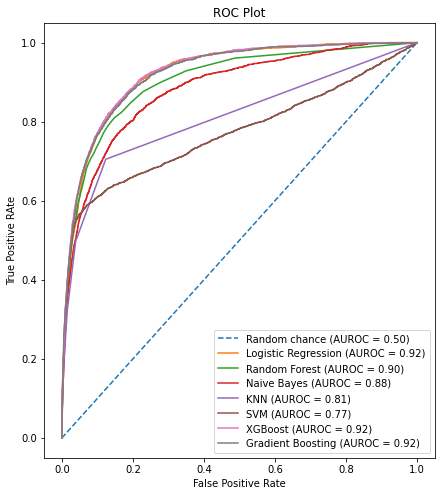

In [24]:
plt.figure(figsize=(7,8))

plt.plot(r_fpr, r_tpr, linestyle='--')
plt.plot(lreg_fpr, lreg_tpr)
plt.plot(rf_fpr, rf_tpr)
plt.plot(nb_fpr, nb_tpr)
plt.plot(knn_fpr, knn_tpr)
plt.plot(svc_fpr, svc_tpr)
plt.plot(xgb_fpr, xgb_tpr)
plt.plot(gbc_fpr, gbc_tpr)

r_legend = 'Random chance (AUROC = %0.2f)' % r_auc
lreg_legend = 'Logistic Regression (AUROC = %0.2f)' % lreg_auc
rf_legend = "Random Forest (AUROC = %0.2f)" % rf_auc
nb_legend = "Naive Bayes (AUROC = %0.2f)" % nb_auc
knn_legend = "KNN (AUROC = %0.2f)" %knn_auc
svc_legend = "SVM (AUROC = %0.2f)" %svc_auc
xgb_legend = "XGBoost (AUROC = %0.2f) " %xgb_auc
gbc_legend = "Gradient Boosting (AUROC = %0.2f) " %gbc_auc

plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive RAte')
plt.legend(labels = [r_legend,lreg_legend, rf_legend,nb_legend, knn_legend,
                     svc_legend,xgb_legend, gbc_legend])
plt.show()